In [1]:
import numpy as np
import math
from scipy.integrate import odeint
import seaborn as sns
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.model_selection import ParameterGrid

In [2]:
# функции
time_lst = lambda stop, tick: np.arange(0.0, stop, tick)

an = lambda v: 0.01 * (v + 55) / (1 - np.exp(-0.1 * (v + 55)))
bn = lambda v: 0.125 * np.exp(-0.0125 * (v + 65))

am = lambda v: 0.1 * (v + 40) / (1 - np.exp(-0.1 * (v + 40)))
bm = lambda v: 4 * np.exp(-0.0556 * (v + 65))

ah = lambda v: 0.07 * np.exp(-0.05 * (v + 65))
bh = lambda v: 1 / (1 + np.exp(-0.1 * (v + 35)))

In [142]:
# структура синапса
class Snps:
    def __init__(self, income, outcome, v_max, receptors, dist_param, time, name):
        if name == 'B':
            k, y =500*1e-9, 10
            delay_dist = lambda: np.random.poisson(dist_param) 
        else:
            k, y =128*1e-9, 8
            delay_dist = lambda: np.random.uniform(0, dist_param)
            
        L = 0.0
        I = dict()
        
        delay = delay_dist()
        for t in time:
        
            if delay <= 0:
                L += income
                delay = delay_dist()
                
            L -= outcome
            L = np.clip(L, 0.0, v_max) 
            l = L / v_max
            po = (l / k) / (1 + (l / k))
            I[t] = receptors * po * y / 1000
            delay -= 1.0
    
        self.I_ = lambda t: I[int(t)]

In [143]:
# отрисовка графиков
def pict(t, V):
    fig = plt.figure(constrained_layout=True, figsize=(20, 30))
    spec = gridspec.GridSpec(ncols=4, nrows=6, figure=fig)

    ax11 = fig.add_subplot(spec[0:1, 0:1])
    ax12 = fig.add_subplot(spec[0:1, 1:2])
    ax13 = fig.add_subplot(spec[0:1, 2:3])
    ax14 = fig.add_subplot(spec[0:1, 3:4])

    ax21 = fig.add_subplot(spec[1:2, 0:2])
    ax22 = fig.add_subplot(spec[1:2, 2:4])
    
    ax51 = fig.add_subplot(spec[2:3, 0:2])
    ax52 = fig.add_subplot(spec[2:3, 2:4])
    

    ax31 = fig.add_subplot(spec[3:4, 0:1])
    ax32 = fig.add_subplot(spec[3:4, 1:2])
    ax33 = fig.add_subplot(spec[3:4, 2:3])
    ax34 = fig.add_subplot(spec[3:4, 3:4])
    
    ax41 = fig.add_subplot(spec[4:5, 0:1], projection = '3d')
    ax42 = fig.add_subplot(spec[4:5, 1:2], projection = '3d')
    ax43 = fig.add_subplot(spec[4:5, 2:3], projection = '3d')
    ax44 = fig.add_subplot(spec[4:5, 3:4], projection = '3d')


    ax11.plot(t, V[:, 0])
    ax11.set_title('Vm(t)')
    ax12.plot(t, V[:, 1])
    ax12.set_title('n(t)')
    ax13.plot(t, V[:, 2])
    ax13.set_title('m(t)')
    ax14.plot(t, V[:, 3])
    ax14.set_title('h(t)')
    
    
    ax21.plot(t, V[:, 4])
    ax21.set_title('I_Snps_A(t) = Cl(t)')
    
    ax22.plot(t, V[:, 5])
    ax22.set_title('I_Snps_B(t)')

    ax31.plot(V[:, 0], V[:, 1])
    ax31.set_title('Vm(n)')
    ax32.plot(V[:, 0], V[:, 2])
    ax32.set_title('Vm(m)')
    ax33.plot(V[:, 0], V[:, 3])
    ax33.set_title('Vm(h)')

    ax34.plot(V[:, 0], V[:, 1])
    ax34.plot(V[:, 0], V[:, 2])
    ax34.plot(V[:, 0], V[:, 3])
    ax34.set_title('Vm(n, m, h)')


    ax41.plot(t, V[:,0], V[:, 1])
    ax41.set_title('Vm(n, t)')
    ax42.plot(t, V[:,0], V[:, 2])
    ax42.set_title('Vm(m, t)')
    ax43.plot(t, V[:,0], V[:, 3])
    ax43.set_title('Vm(h, t)')

    ax44.plot(t, V[:,0], V[:, 1], linewidth = 0.5)
    ax44.plot(t, V[:,0], V[:, 2], linewidth = 0.5)
    ax44.plot(t, V[:,0], V[:, 3], linewidth = 0.5)
    ax44.set_title('Vm(n, m, h, t)')
    
    ax51.plot(t, V[:, 7])
    ax51.set_title('I_K(t)')
    
    ax52.plot(t, np.sum(V[:, 5:7], axis=1))
    ax52.set_title('I_Na(t)')
    

    for mg in [ax11, ax12, ax13, ax14, ax21, ax22, ax51, ax52]:
        mg.grid()

    plt.show()

In [144]:
def drvs(y, t, arguments):
    v, n, m, h, _, _, _, _,  = y
    gK, gNa, EK, ENa, Cm, A, vA, B, vB  = arguments
    
    x_K = gK * (n ** 4) * (v-EK)
    x_Na = gNa * (m ** 3) * h * (v-ENa)
    x_A = A.I_(t) * (v-vA)
    x_B = B.I_(t) * (v-vB)
    
    dv = -(x_K + x_Na + x_A + x_B) / Cm
    
    dndt = an(v) * (1-n) - bn(v) * n
    dmdt = am(v) * (1-m) - bm(v) * m
    dhdt = ah(v) * (1-h) - bh(v) * h
    # A = GABA = хлор
    # B = GLU = натрий
    return np.array([dv, dndt, dmdt, dhdt, x_A, x_B, x_Na, x_K])

In [359]:
time = time_lst(6000, 1) # 60 s, значит один тик это 10 ms
# синапсы
A = Snps(500, 10, 500, 100, 45, time, 'A')
B = Snps(100, 10, 500, 100, 20, time, 'B')

# константы
gK = 36.0
gNa = 120.0
EK = -77.0
ENa = 50.0
vA = -65.0
vB = 55.0
Cm = 1.0

In [360]:
invals = np.zeros(8)
arguments = [gK, gNa, EK, ENa, Cm, A, vA, B, vB]
V = odeint(drvs, invals, time, args=(arguments,))

In [361]:
# проверим выживаемость кота
pos_ = V[:, 0] > 0
spikes = (pos_[1:] == True) & (pos_[:-1] == False) # когда следующий положительный, а сейчас отрицательный
num_spikes_500ms = pd.Series(spikes).rolling(50).sum().dropna() # считаем число спайков по окну в 50 (500 ms)
num_spikes = pd.Series(spikes).rolling(100).sum().dropna()

In [362]:
(num_spikes_500ms == 0.0).sum() # не существует промежутка в 500 ms, чтобы не было спайка

0

In [363]:
(num_spikes >= 10.0).sum() # частота свыше 10

0

In [364]:
num_spikes.value_counts() # дотянул только до 7

5.0    3280
4.0    1807
6.0     733
3.0      66
7.0      14
dtype: int64

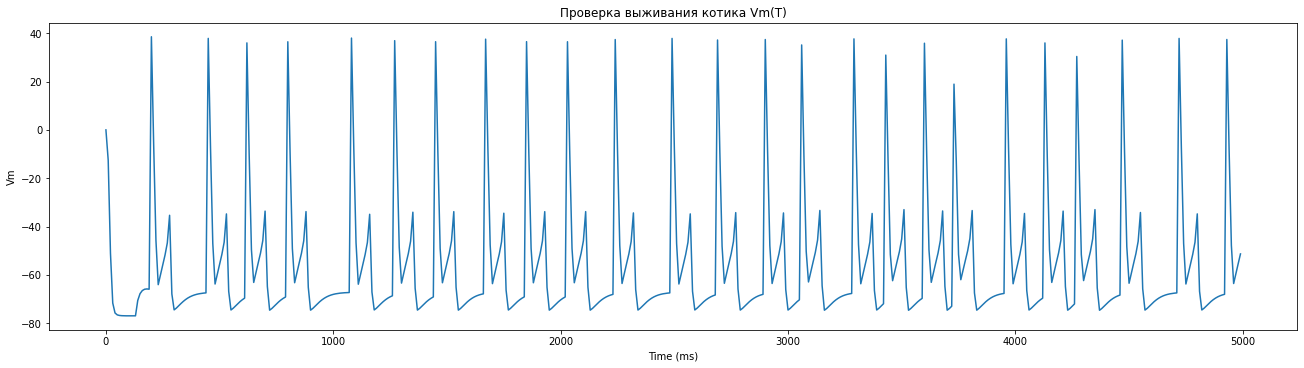

In [365]:
fig = plt.figure(constrained_layout=True, figsize=(18, 5))
plt.plot(time[:500] * 10, V[:,0][:500])
plt.xlabel('Time (ms)')
plt.ylabel('Vm')
plt.title('Проверка выживания котика Vm(T)')
plt.show()

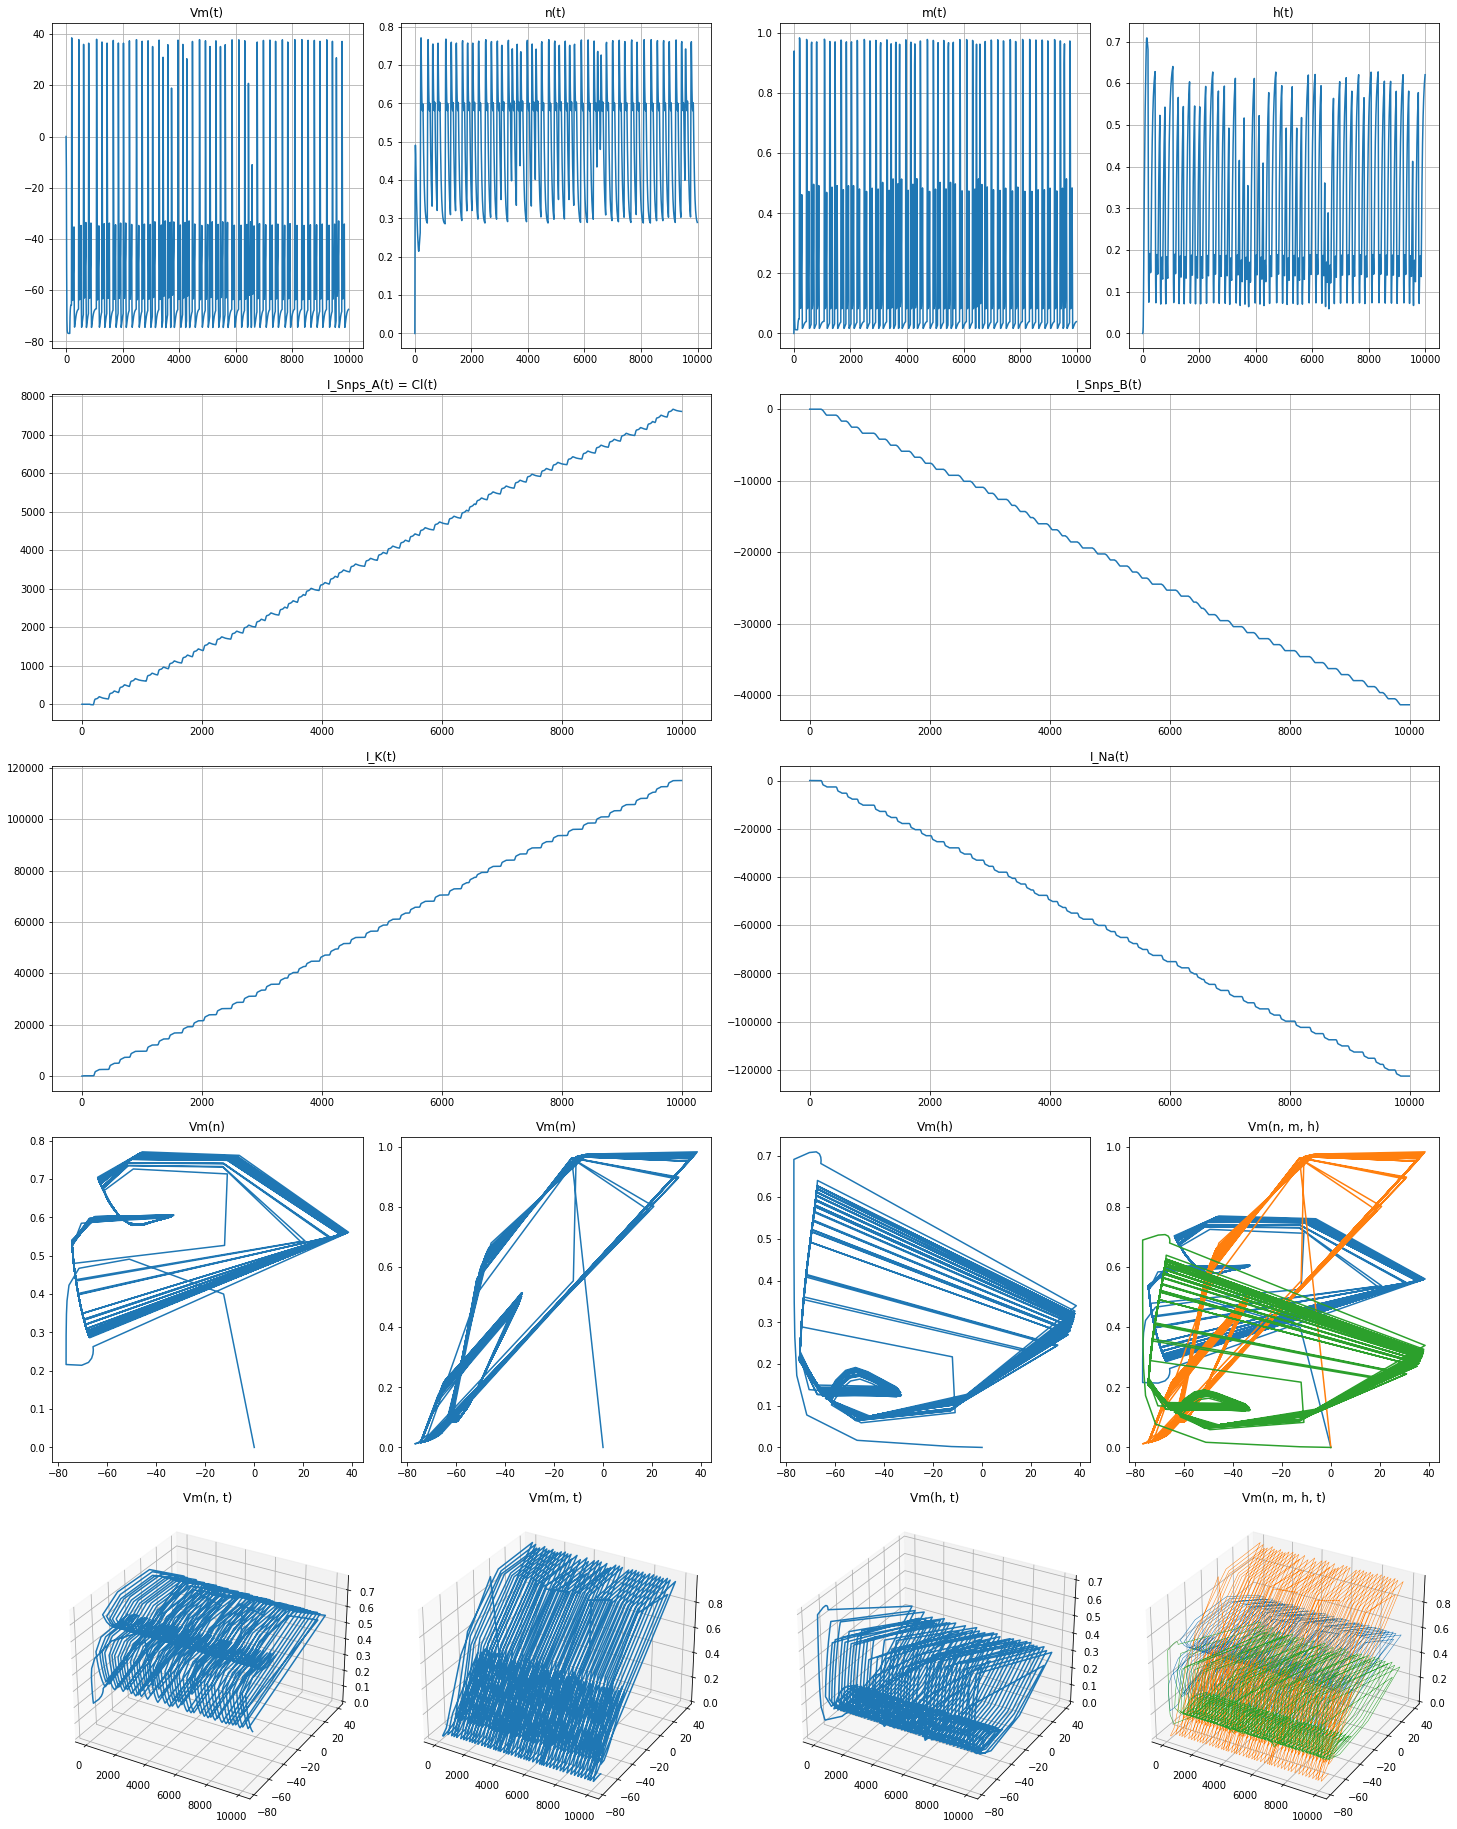

In [366]:
pict(time[:1000] * 10, V[:1000])